# Neural network based calibration of the rough Bergomi model
We calibrate the rough Bergomi model using the neural network trained in https://github.com/sigurdroemer/rough_volatility

### Import libraries and set directories
Start with setting the root directory so we can import utilities in other folders in this repo.

In [1]:
import sys
import os
from base_fns import get_local_folder

DIR = get_local_folder()
ROOTDIR = os.path.dirname(DIR)
sys.path.append(ROOTDIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from NeuralNetworkPricing import NeuralNetworkPricer
from utils.svi import svi
from plotutils import plot_fit

### Define the model
Define neural network based (rough Bergomi) model.

In [3]:
weights_folder = DIR + "\\nn_weights"
contracts_folder = DIR
model = NeuralNetworkPricer(contracts_folder, weights_folder, "rbergomi")

### Target Vol Surface
Read the vol surface for 2005 Sep 09 (in SVI).

In [4]:
svi_file = ROOTDIR + "\\data\\spx_svi_2005_09_15.csv"
svi_df = pd.read_csv(svi_file, parse_dates=["date"])
expirations = list(svi_df["date"][1:-2])  # Skip the last two expirations

Generate target vols for a range of strikes, and remove those not in the domain for the NN.

In [5]:
# candidate log strikes for any expiration before filtering
k_candidates = np.arange(-0.5, 0.5, 0.02).reshape(-1, 1)

k_orig = []
T_orig = []
k_obs = []
T_obs = []
iv_obs = []

for i, exp in enumerate(expirations):
    params = svi_df[svi_df["date"] == exp].iloc[0]

    t_candidates = k_candidates * 0 + params["texp"]
    idxKeep = model.AreContractsInDomain(k_candidates, t_candidates)
    k_obs_sub = k_candidates[idxKeep, :]
    T_obs_sub = t_candidates[idxKeep, :]

    w = svi(params, k_obs_sub)
    svi_iv_sub = np.sqrt(w / params["texp"])
    k_orig.extend(k_candidates)
    T_orig.extend(t_candidates)
    k_obs.extend(k_obs_sub)
    T_obs.extend(T_obs_sub)
    iv_obs.extend(svi_iv_sub)

Plot the strike and Terms of the contracts being used for calibration.

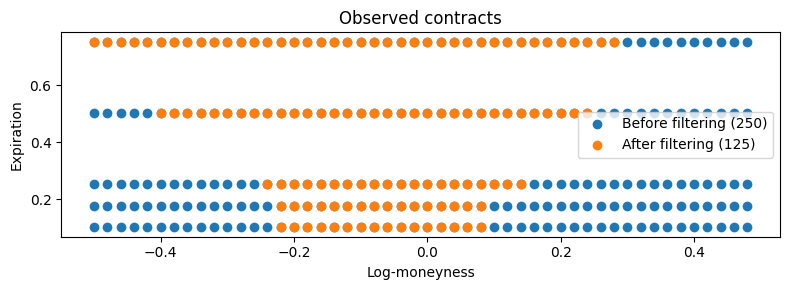

In [6]:
# Plot contracts before and after filtering:
plt.figure(figsize=(8, 3))
plt.scatter(k_orig, T_orig, label=f"Before filtering ({len(k_orig)})")
plt.scatter(k_obs, T_obs, label=f"After filtering ({len(k_obs)})")
plt.title("Observed contracts")
plt.ylabel("Expiration")
plt.xlabel("Log-moneyness")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Turn into column vectors for the model
iv_obs = np.array(iv_obs).reshape(-1, 1)
k_obs = np.array(k_obs).reshape(-1, 1)
T_obs = np.array(T_obs).reshape(-1, 1)

### Calibrate the model using the NN.
Remark: In this version we force the forward variance curve (Xi) flat, which is params[3:]. This also avoids an overparameterised model.


In [8]:
# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
modelbounds = []
eps = pow(10, -6)
for i in range(0, len(model.lb)):
    modelbounds.append([model.lb[i] + eps, model.ub[i] - eps])

# Fix the forward variance curve flat:
idxConvPar = np.concatenate((np.array([0, 1, 2]), 3 * np.ones(27))).astype(int)
par0 = np.array([0.2, 1.6, -0.7, pow(0.25, 2)])


# Define the error function:
def err_fun(parEval):
    return np.sum(
        pow(
            iv_obs
            - model.Eval(parEval[idxConvPar].reshape(-1, 1), k_obs, T_obs),
            2,
        )
    )


# Optimize:
res = minimize(err_fun, par0, method="L-BFGS-B", bounds=modelbounds[0:4])
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1, 1)

# Print calibrated parameters:
print(parCalib.reshape(-1))

Optimisation message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[ 0.11323729  1.71616126 -0.71437993  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351]


### Plot the fit

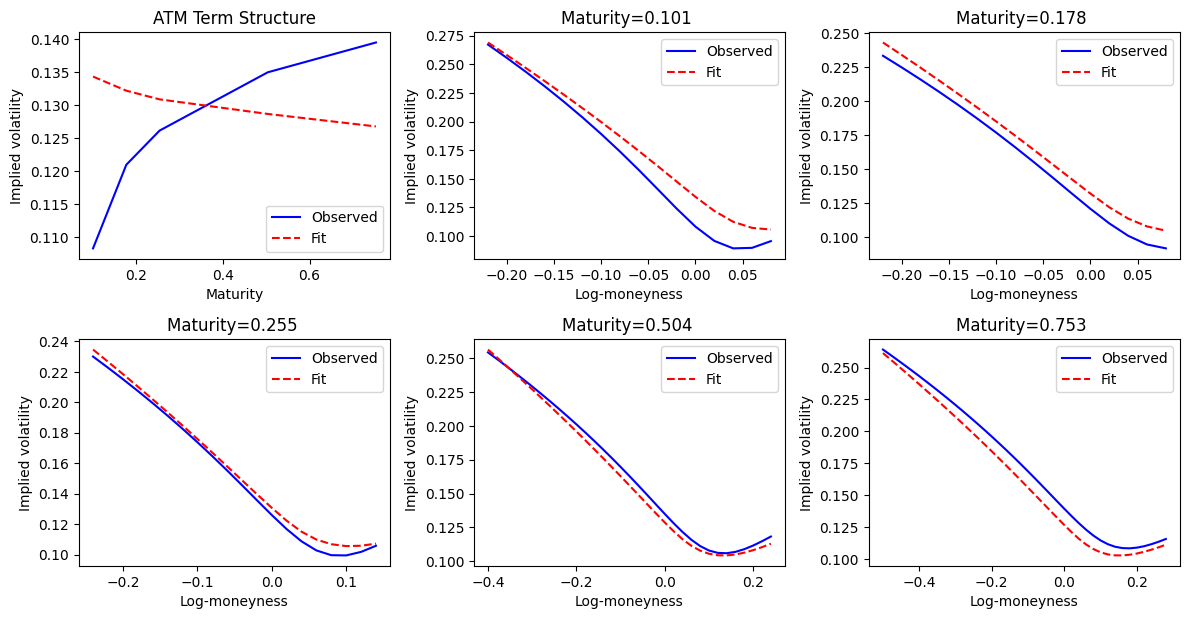

In [9]:
plot_fit(model, parCalib, k_obs, T_obs, iv_obs)

### Allow a non flat variance curve to improve the fit.
The flat forward variance was unable to fit the term structure well. So will try again, this time forcing the forward variance to have a term structure like

$$
\xi_t = x_4 + exp(-x_5 * t) * (x_3 - x_4)
$$

In [10]:
# Choose a parameteric shape for the forward variance curve with two paramters:
txi = model.Txi


def param_full(x):
    xi = x[4] + np.exp(-x[5] * txi) * (x[3] - x[4])
    return np.concatenate((x[:3], xi))


bounds = modelbounds[0:6]
bounds[5] = [0, 10]  # Bounds for the decay parameter
par0 = np.array([0.2, 1.6, -0.7, 0.02, 0.05, 5])


# Define the error function:
def err_fun(parEval):
    return np.sum(
        pow(
            iv_obs
            - model.Eval(param_full(parEval).reshape(-1, 1), k_obs, T_obs),
            2,
        )
    )


# Optimize:
res = minimize(err_fun, par0, method="L-BFGS-B", bounds=bounds)
print("Optimisation message: ", res.message)
print(res.x)
parCalib = param_full(res.x).reshape(-1, 1)

print(parCalib.reshape(-1))

Optimisation message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[ 0.04131844  2.02720156 -0.97382728  0.01313237  0.02826082  4.9101388 ]
[ 0.04131844  2.02720156 -0.97382728  0.01331694  0.01349926  0.01367936
  0.01385726  0.01403299  0.01420657  0.01437804  0.01454741  0.01583009
  0.0169928   0.01804675  0.01900213  0.01986814  0.02065315  0.02136473
  0.02443513  0.02613848  0.02708342  0.02760765  0.02789846  0.0280598
  0.0281493   0.02822814  0.02825124  0.02825801  0.02826     0.02826081]


### Plot again

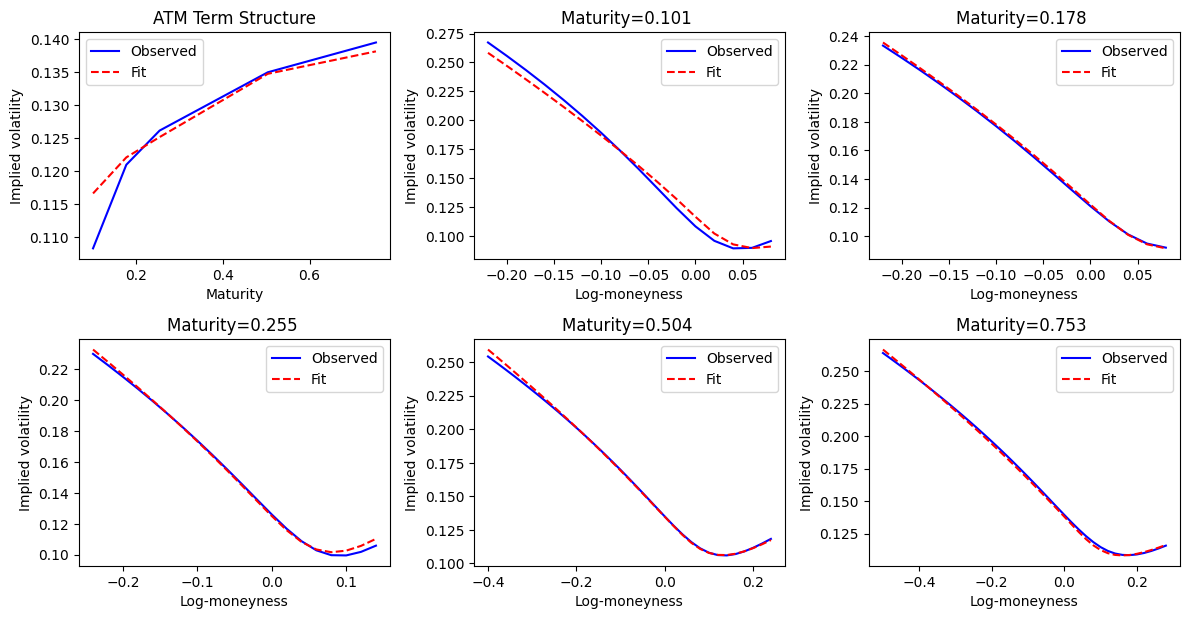

In [11]:
# Print calibrated parameters:
plot_fit(model, parCalib, k_obs, T_obs, iv_obs)